Should we calculate difference? https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

Convert wind dirs to degrees for numerical values? https://study.com/cimages/multimages/16/cb_1_copy.jpeg
    - No: convert to direction vector: https://www.tensorflow.org/tutorials/structured_data/time_series
    
Major issue to resolve - data is not strictly time series as it contains the data from many sites over time, with overlapping time frames. How to prevent model from considering one site's time series data as an extension of the previous site's?

In [23]:
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('weatherAUS.csv')
# data.info()

In [24]:
# locs = pd.read_csv('locations.csv')
# bbox = (locs.lon.min(), locs.lon.max(), locs.lat.min(), locs.lat.max())
# bbox = (101, 161, 1, -48)

# m = plt.imread('map.png')

# fig, ax = plt.subplots(figsize=(20, 20))
# ax.scatter(locs.lon, locs.lat, zorder=1, alpha=0.2, c='b', s=1000)
# ax.set_xlim(bbox[0], bbox[1])
# ax.set_ylim(bbox[2], bbox[3])
# ax.imshow(m, zorder=0, extent=bbox, aspect='equal')

In [25]:
data['Location'].value_counts()

Canberra            3418
Sydney              3337
Perth               3193
Darwin              3192
Hobart              3188
Brisbane            3161
Adelaide            3090
Bendigo             3034
Townsville          3033
AliceSprings        3031
MountGambier        3030
Launceston          3028
Ballarat            3028
Albany              3016
Albury              3011
PerthAirport        3009
MelbourneAirport    3009
Mildura             3007
SydneyAirport       3005
Nuriootpa           3002
Sale                3000
Watsonia            2999
Tuggeranong         2998
Portland            2996
Woomera             2990
Cairns              2988
Cobar               2988
Wollongong          2983
GoldCoast           2980
WaggaWagga          2976
Penrith             2964
NorfolkIsland       2964
Newcastle           2955
SalmonGums          2955
CoffsHarbour        2953
Witchcliffe         2952
Richmond            2951
Dartmoor            2943
NorahHead           2929
BadgerysCreek       2928


In [26]:
(data.isna().sum() / data.shape[0]) * 100 # what percent of each column is NA?
data["RainTomorrow"].value_counts() # our data is not balanced between classes

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

In [27]:
# convert to binary
data["RainTomorrow"].replace(('Yes', 'No'), (1, 0), inplace=True)
data["RainToday"].replace(('Yes', 'No'), (1, 0), inplace=True)
data.drop(columns=['Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'RISK_MM'], inplace=True)

# convert direction strings to degrees
data['WindGustDir'].replace(
    ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
    (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
    inplace=True
)

data['WindDir9am'].replace(
    ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
    (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
    inplace=True
)

data['WindDir3pm'].replace(
    ('N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW','SW','WSW','W','WNW','NW','NNW'),
    (0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5, 180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5),
    inplace=True
)

In [28]:
# drop na in listed columns
data.dropna(
    axis=0, how='any',
    subset=['WindGustDir','WindDir9am','WindDir3pm','WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm'],
    inplace=True
)

data_date = pd.to_datetime(data.pop('Date'))

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

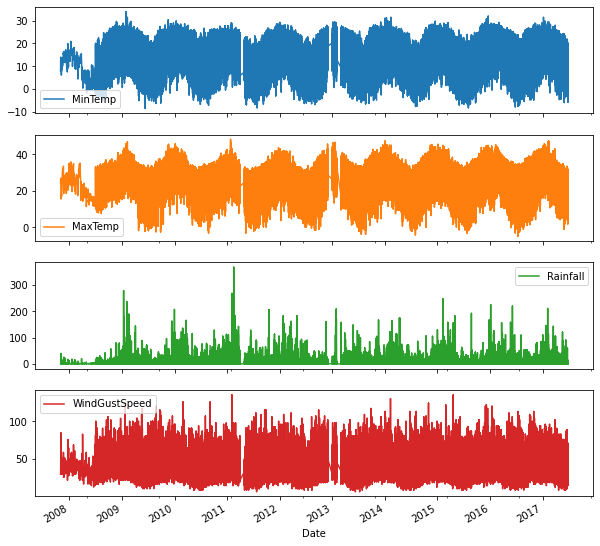

In [30]:
# plot features over time
plot_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed']
# plot_cols = ['Rainfall']
plot_features = data[plot_cols]
plot_features.index = data_date
plot_features.plot(subplots=True, figsize=(10,10))

In [10]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MinTemp,124528.0,12.417752,6.364824,-8.5,7.8,12.2,17.1,33.9
MaxTemp,124620.0,23.472416,7.201660,-4.8,18.1,23.0,28.6,48.1
Rainfall,123710.0,2.375661,8.528039,0.0,0.0,0.0,0.8,367.6
WindGustDir,124668.0,170.061543,100.374910,0.0,90.0,180.0,247.5,337.5
WindGustSpeed,124668.0,40.695263,13.397250,7.0,31.0,39.0,48.0,135.0
WindDir9am,124668.0,162.105833,104.636639,0.0,67.5,157.5,247.5,337.5
WindDir3pm,124668.0,172.020286,100.846253,0.0,90.0,180.0,270.0,337.5
WindSpeed9am,124668.0,15.022123,8.315155,2.0,9.0,13.0,20.0,87.0
WindSpeed3pm,124668.0,19.180993,8.575571,2.0,13.0,19.0,24.0,87.0
Humidity9am,123636.0,67.673906,19.040380,0.0,56.0,69.0,82.0,100.0


Text(0, 0.5, 'Wind Velocity [m/s]')

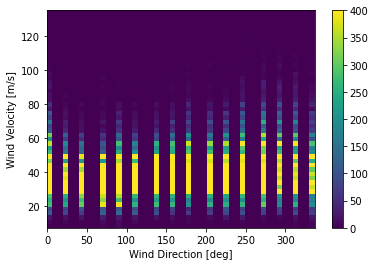

In [11]:
# plot distribution of wind data
plt.hist2d(data['WindGustDir'], data['WindGustSpeed'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [12]:
# convert all wind data to vectors
wv = data.pop('WindGustSpeed')
wd = data.pop('WindGustDir')*np.pi/180
data['WindGustX'] = wv*np.cos(wd)
data['WindGustY'] = wv*np.sin(wd)

wv = data.pop('WindSpeed9am')
wd = data.pop('WindDir9am')*np.pi/180
data['Wind9amX'] = wv*np.cos(wd)
data['Wind9amY'] = wv*np.sin(wd)

wv = data.pop('WindSpeed3pm')
wd = data.pop('WindDir3pm')*np.pi/180
data['Wind3pmX'] = wv*np.cos(wd)
data['Wind3pmY'] = wv*np.sin(wd)

(-135.0, 107.0, -126.0, 135.0)

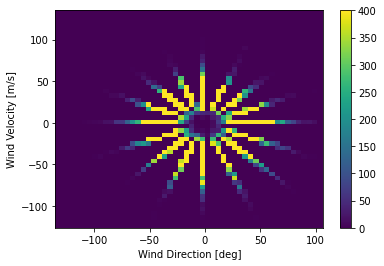

In [13]:
# plot distribution of new wind vectors
plt.hist2d(data['WindGustX'], data['WindGustY'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')
ax = plt.gca()
ax.axis('tight')

In [14]:
timestamp_s = data_date.map(datetime.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day
data['daysin'] = np.sin(timestamp_s * (2 * np.pi/day))
data['daycos'] = np.cos(timestamp_s * (2 * np.pi/day))
data['yearsin'] = np.sin(timestamp_s * (2 * np.pi/year))
data['yearcos'] = np.cos(timestamp_s * (2 * np.pi/year))

In [15]:
# split and normalize all the data
n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df = data[int(n*0.9):]


train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std

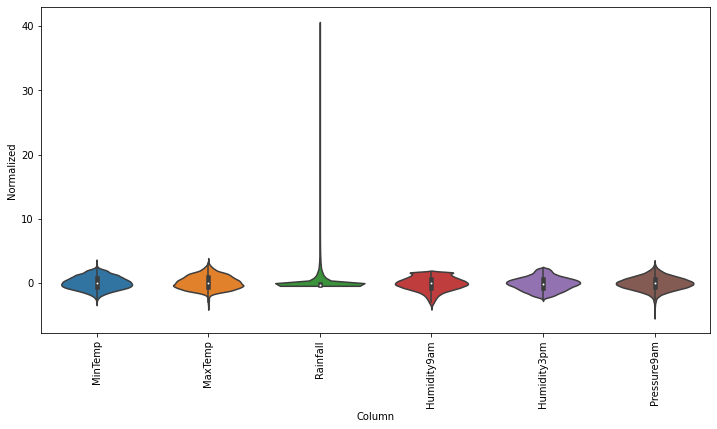

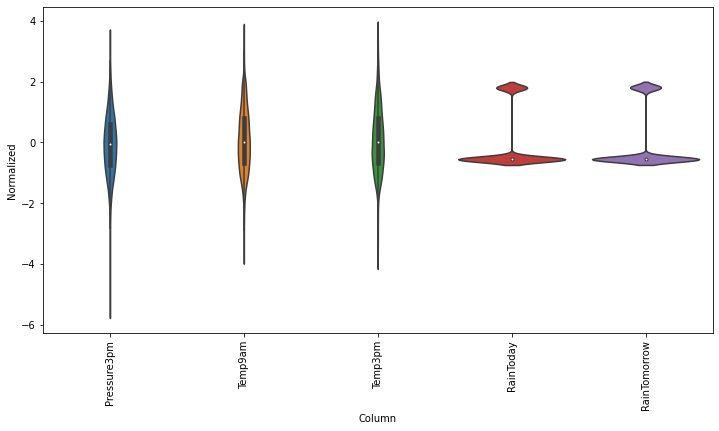

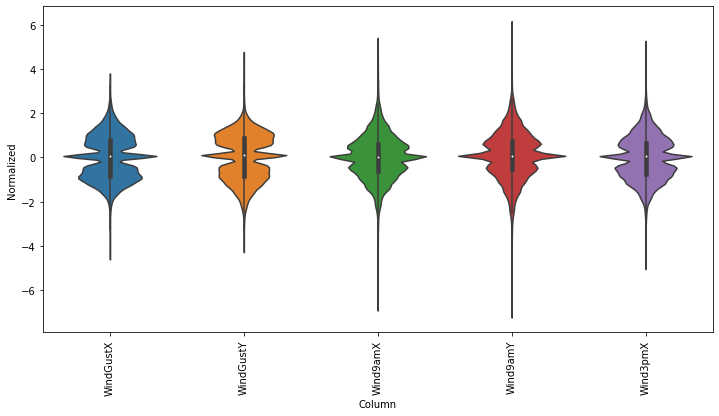

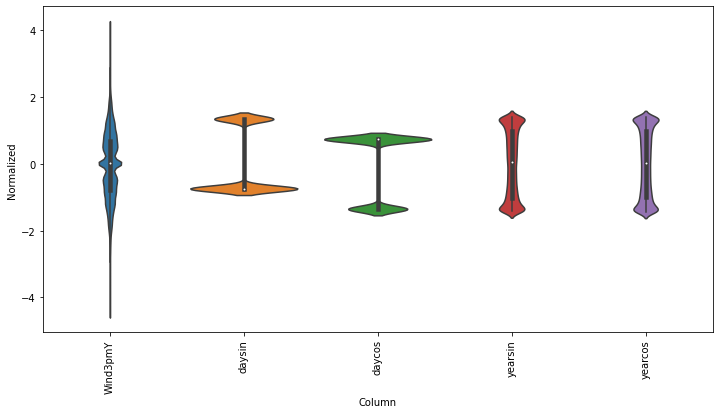

In [16]:
data_std = (data - train_mean) / train_std
data_melted = data_std.melt(var_name='Column', value_name='Normalized')
var_rows = int(data_melted.shape[0]/21) # number of rows for each variable

plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=data_melted[:var_rows*6])
_ = ax.set_xticklabels(data.keys()[:6], rotation=90)

plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=data_melted[var_rows*6:var_rows*11])
_ = ax.set_xticklabels(data.keys()[6:11], rotation=90)

plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=data_melted[var_rows*11:var_rows*16])
_ = ax.set_xticklabels(data.keys()[11:16], rotation=90)

plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=data_melted[var_rows*16:var_rows*21])
_ = ax.set_xticklabels(data.keys()[16:21], rotation=90)

In [17]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#1_indexes_and_offsets
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='RainTomorrow', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [18]:
w = WindowGenerator(input_width = 1, label_width=1, shift=1, label_columns=['RainTomorrow'])
# w.plot()

In [19]:
for example_inputs, example_labels in w.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 21)
Labels shape (batch, time, features): (32, 1, 1)


In [20]:
epochs = 20

linear_model = keras.Sequential([
    keras.layers.Dense(units=1, activation='sigmoid')
])

val_performance = {}
performance = {}

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    model.compile(loss=tf.losses.BinaryCrossentropy(), optimizer=tf.optimizers.Adam(),
        metrics=[tf.metrics.BinaryAccuracy()])
    
#     model.compile(loss='binary_crossentropy', optimizer='adam')
    
    history = model.fit(window.train, epochs=epochs, validation_data=window.val, callbacks=[early_stopping])
    return history    

In [21]:
# does not work, loss is nan and biary_accuracy is always 0

history = compile_and_fit(linear_model, w)

val_performance['Linear'] = linear_model.evaluate(w.val)
performance['Linear'] = linear_model.evaluate(w.test, verbose=0)

Epoch 1/20
2719/2728 [============================>.] - ETA: 0s - loss: nan - binary_accuracy: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
# loss and bin_acc are still nan and 0
dense_model = keras.Sequential([
    keras.layers.Dense(units=64, activation='sigmoid'),
    keras.layers.Dense(units=64, activation='sigmoid'),
    keras.layers.Dense(units=1)
])

history = compile_and_fit(dense_model, w)
val_performance['Dense'] = dense_model.evaluate(w.val)
performance['Dense'] = dense_model.evaluate(w.test, verbose=0)